In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR

from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

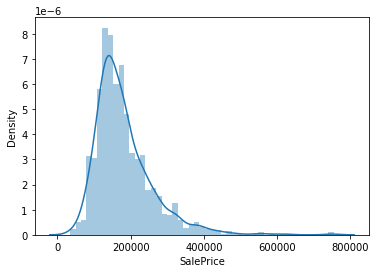

In [4]:
sns.distplot(train['SalePrice'])

In [5]:
train.SalePrice.skew()

1.8828757597682129

In [6]:
numeric_dtypes=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num,cat=[],[]
for col in train.columns:
    if train[col].dtype in numeric_dtypes: num.append(col)
    else: cat.append(col)
print(len(num),len(cat))

38 43


In [7]:
num=num[:-1]

<AxesSubplot:>

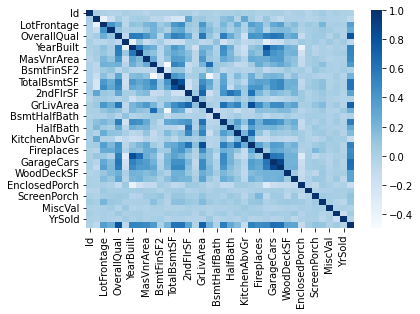

In [8]:
corr=train.corr()
sns.heatmap(corr,cmap='Blues')

In [9]:
corr['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

In [10]:
#High correlation numeric data
num_to_use=list(corr[abs(corr['SalePrice'])>0.02]['SalePrice'][:-1].index)

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

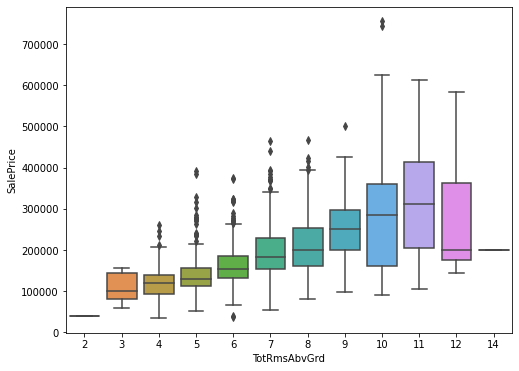

In [11]:
data=pd.concat([train['SalePrice'],train['TotRmsAbvGrd']],axis=1)
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x=train['TotRmsAbvGrd'],y=train['SalePrice'],data=data)

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

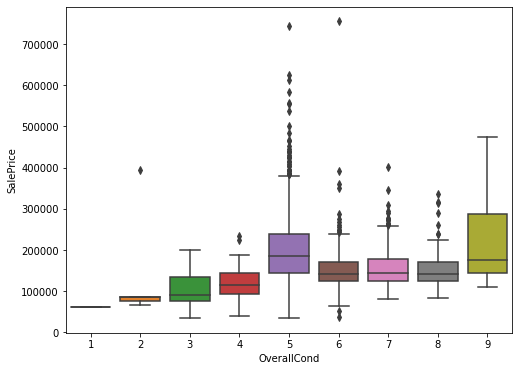

In [12]:
data=pd.concat([train['SalePrice'],train['OverallCond']],axis=1)
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x=train['OverallCond'],y=train['SalePrice'],data=data)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

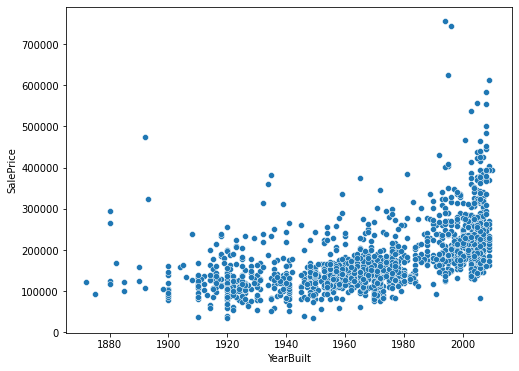

In [13]:
data=pd.concat([train['SalePrice'],train['YearBuilt']],axis=1)
f,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],data=data)

In [14]:
#Eliminate outliers
train.drop(train[(train['TotRmsAbvGrd']==10) &
                 (train['SalePrice']>700000)].index,inplace=True)
train.drop(train[(train['FullBath']<=1) &
                 (train['SalePrice']>380000)].index,inplace=True)
train.drop(train[(train['GarageCars']==3) &
                 (train['SalePrice']>700000)].index,inplace=True)
train.drop(train[(train['OverallCond']<5) &
                 (train['SalePrice']>300000)].index,inplace=True)
train.drop(train[(train['OverallCond']==5) &
                 (train['SalePrice']>600000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) &
                 (train['SalePrice']<250000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) &
                 (train['SalePrice']<250000)].index,inplace=True)
train.drop(train[(train['YearBuilt']<1920) &
                 (train['SalePrice']>200000)].index,inplace=True)
#Reset index
train.reset_index(drop=True,inplace=True)

In [15]:
removed=['Alley', 'PoolQC', 'Fence', 'MiscFeature','FireplaceQu','LotFrontage']
for col in cat:
    if col in removed: 
        cat.remove(col)

<AxesSubplot:>

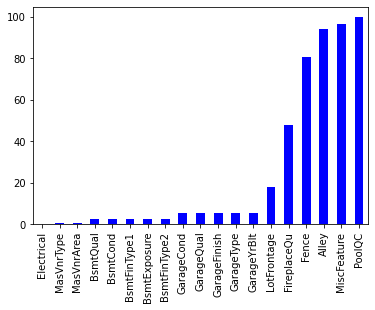

In [16]:
missing=round(train.isnull().mean()*100,2)
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

In [17]:
skew_features=train[num_to_use].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew=skew_features[skew_features>0.4]
high_skew
#high_skew_index=high_skew.index
#for col in high_skew_index:
#    train[col]=boxcox1p(train[col],boxcox_normmax(train[col] + 1))
#    test[col]=boxcox1p(test[col],boxcox_normmax(train[col] + 1))

MiscVal          24.309097
PoolArea         19.408815
LotArea          13.034243
3SsnPorch        10.232026
LowQualFinSF      9.425659
KitchenAbvGr      4.453806
ScreenPorch       4.095550
EnclosedPorch     2.827852
OpenPorchSF       2.235607
WoodDeckSF        1.466894
MSSubClass        1.404485
BsmtUnfSF         0.927943
1stFlrSF          0.875335
2ndFlrSF          0.752788
GrLivArea         0.748119
BsmtFinSF1        0.701614
HalfBath          0.698112
OverallCond       0.691330
TotRmsAbvGrd      0.652825
Fireplaces        0.643017
BsmtFullBath      0.587490
TotalBsmtSF       0.479050
dtype: float64

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('std_scalar', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_to_use),
        ('cat', categorical_transformer, cat)
    ])
from sklearn.ensemble import RandomForestRegressor

model1 = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42,validation_fraction=0.2)  

# Bundle preprocessing and modeling code in a pipeline
my_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model1)
                             ])

In [19]:
y_train=train['SalePrice']
train.drop(['SalePrice'],inplace=True,axis=1)

In [20]:
final_cols=num_to_use+cat

In [21]:
X_train=train[final_cols]

In [22]:
testId=test['Id']
X_test=test[final_cols]

In [23]:
my_pipeline1.fit(X_train,y_train)
preds=my_pipeline1.predict(X_test)

In [24]:
preds

array([127225.50386748, 160895.12384158, 188099.30171657, ...,
       164546.28000793, 118982.31562225, 215270.4224113 ])

In [25]:
submission=pd.DataFrame({'Id':testId, 'SalePrice':preds})
submission.to_csv('./submission.csv',index=False)